Assignment2
This week's assignment is to:
1. Load a graph database of your choosing from a text file or other source. If you take a
large network dataset from the web (such as from https://snap.stanford.edu/data/), please
feel free at this point to load just a small subset of the nodes and edges.
2. Create basic analysis on the graph, including the graph’s diameter, and at least one other
metric of your choosing. You may either code the functions by hand (to build your
intuition and insight), or use functions in an existing package.
3. Use a visualization tool of your choice (Neo4j, Gephi, etc.) to display information.
4. Please record a short video (~ 5 minutes), and submit a link to the video as part of your
homework submission.


Enviorment Set up

In [76]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

This notebook analayzes network data for character relationships within George R. R. Martin's A Storm of Swords, the third novel in his series A Song of Ice and Fire (also known as the HBO television adaptation Game of Thrones). This data was originally compiled by A. Beveridge and J. Shan, "Network of Thrones," Math Horizons Magazine , Vol. 23, No. 4 (2016), pp. 18-22.

Data & Methodology
Nodes: 107; unimodal

Edges: 353; weighted; undirected

The nodes csv contains 107 different characters, and the edges csv contains 353 weighted relationships between those characters, which were calculated based on how many times two characters' names appeared within 15 words of one another in the novel. For more on the methodology, see Beveridge and Shan's original article.


In [77]:
# loading data using the pandas library read_csv function
nodes= pd.read_csv('got-nodes.csv')
edges= pd.read_csv('got-edges.csv')

Comfirming data 

In [78]:
print(nodes.head())
print(edges.head()) 

        Id    Label
0    Aemon    Aemon
1    Grenn    Grenn
2  Samwell  Samwell
3    Aerys    Aerys
4    Jaime    Jaime
  Source   Target  Weight
0  Aemon    Grenn       5
1  Aemon  Samwell      31
2  Aerys    Jaime      18
3  Aerys   Robert       6
4  Aerys   Tyrion       5


Our edges are weighted, and the methodologies are detailed in the article’s sources section. 
In short, the weight is determined by how often two characters’ names appear within 15 words of each other.


In [79]:
# Lets initalize a graph object using networkx library
G= nx.Graph()

# Adding node attributes from the nodes dataframe

G.add_nodes_from(nodes["Id"])
G.add_weighted_edges_from(
    edges[["Source", "Target", "Weight"]].itertuples(index=False, name=None)
)


Simple Graph of the network

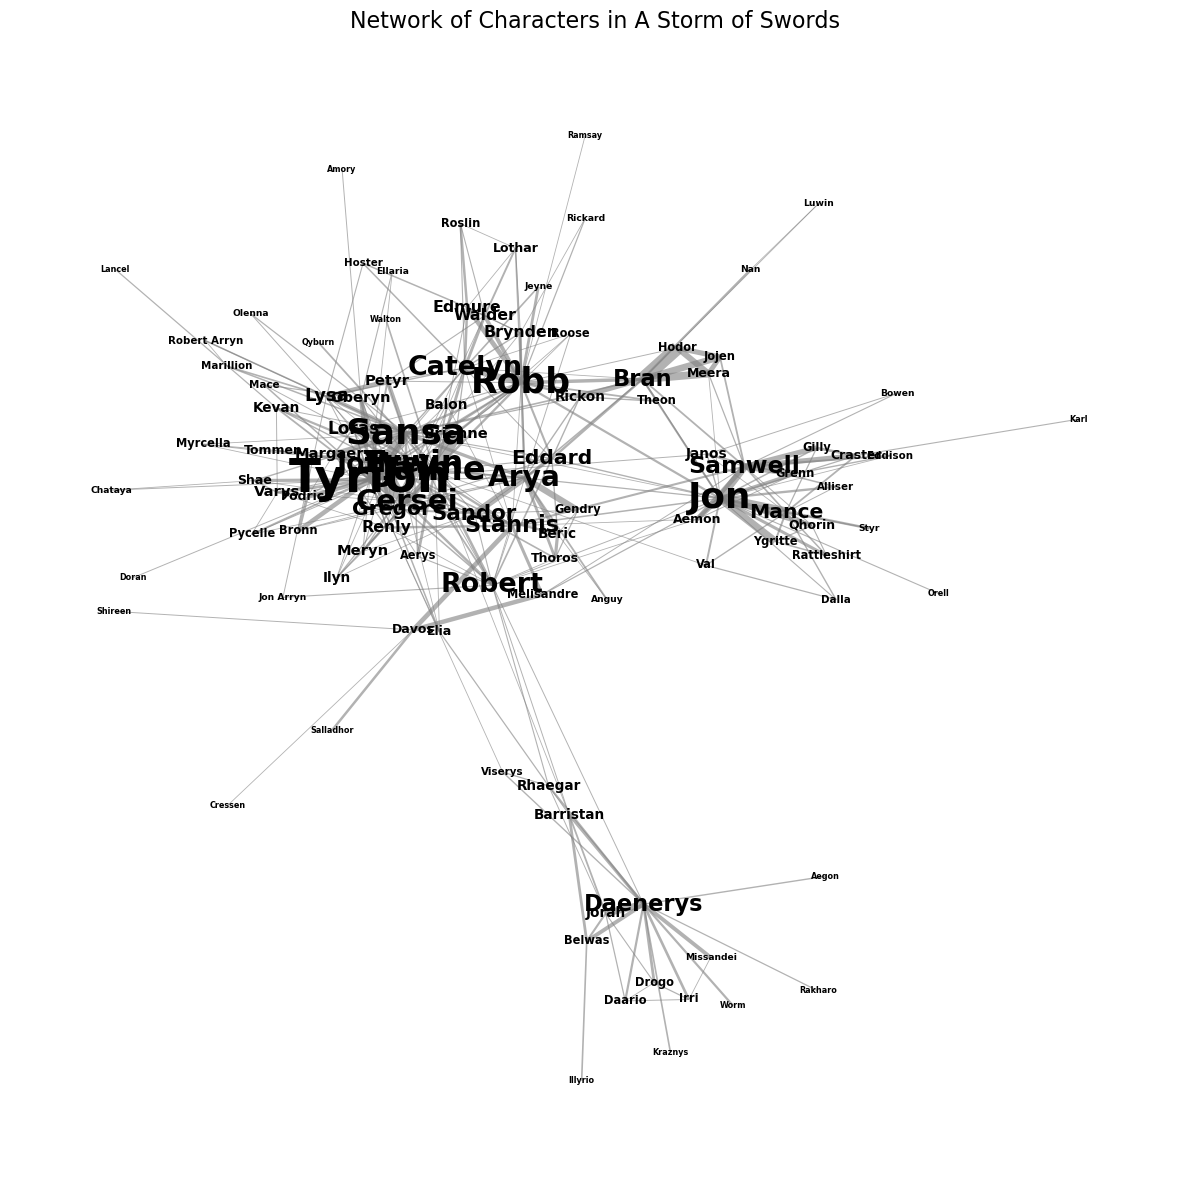

In [80]:
# pos = nx.spring_layout(G, seed=1000, weight='weight', k=0.3) 

# --- Calculate drawing parameters based on graph properties ---
# Get the weighted degree for each node (for node size, if uncommented later)
weighted_degree = dict(G.degree(weight='weight'))

# Normalize node sizes for better visualization
# Using a log-scale can prevent a few highly-connected nodes from dominating the plot.
# We also add a small constant to handle nodes with a degree of 0.
node_sizes = [150 + 8 * weighted_degree.get(n, 0) for n in G] # Use .get(n,0) for safety with isolated nodes

# Create a list of edge widths
edge_widths = [0.2 + 0.1 * G[u][v]["weight"] for u, v in G.edges()]

# --- MODIFICATION START: Calculate label sizes based on UNWEIGHTED degree (DOC) ---
# Get the unweighted degree for each node
degree_centrality = dict(G.degree()) 

# Create a dictionary of label sizes, scaling them based on unweighted degree
# Adjust 'base_font_size' and 'font_multiplier' as needed for visual clarity
base_font_size = 5
font_multiplier = .8
label_sizes = {node: base_font_size + font_multiplier * degree_centrality[node] for node in G.nodes()}
# --- MODIFICATION END ---

# --- Plotting the graph ---
plt.figure(figsize=(12, 12)) # Increase figure size for better label visibility

# Draw edges first to ensure nodes and labels appear on top
nx.draw_networkx_edges(
    G,
    pos,
    width=edge_widths,
    alpha=0.6,
    edge_color="gray"
)

# Draw nodes, with larger, more central nodes standing out (uncomment if you want to draw nodes)
# nx.draw_networkx_nodes(
#     G,
#     pos,
#     node_size=node_sizes,
#     node_color="#87ceeb",
#     edgecolors="#444",
#     linewidths=0.5
# )


# Draw labels, with a different font style and size for readability
nx.draw_networkx_labels(
    G,
    pos,
    font_size=label_sizes, # Use the dictionary for variable font sizes based on DOC
    font_weight="bold",
    font_family="sans-serif",
    clip_on=False # Prevents labels from being clipped at the plot boundary
)

# Add a title and remove the axis
plt.title("Network of Characters in A Storm of Swords", fontsize=16)
plt.axis("off")

# Display the plot
plt.tight_layout() # Adjusts the plot to prevent labels from overlapping
plt.show()

As we can see its hard to make sense of the network in this format, lets get some more information about our network.

Diameter: In graph theory, the diameter of a graph is the largest shortest-path distance between any two vertices. Equivalently, for each vertex you measure its eccentricity (the greatest distance to any other vertex); the diameter is the maximum eccentricity in the graph.

Average Shortest Path:Average shortest path length (ASP) is the mean of all shortest-path distances between every pair of reachable nodes in a graph. In other words, for each pair of nodes you find the length of the shortest route connecting them, then simply average those values. It captures how many steps, on average, it takes to get from one node to another along the network.

Degree of Centrality:Degree centrality measures how many direct connections a node has, normalized by the maximum possible number of connections in the network. It reflects how immediate a node’s reach is—the more neighbors, the higher its degree centrality.


In [81]:
# Calculating basic graph metrics
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
diameter = nx.diameter(G)
print("Diameter:", diameter)


Number of nodes: 107
Number of edges: 352
Diameter: 6


In [82]:

# Average Shortest Path Length
if nx.is_connected(G):
    apl = nx.average_shortest_path_length(G, weight=None)  # weight="weight" if using weighted distances
else:
    largest_cc = G.subgraph(max(nx.connected_components(G), key=len)).copy()
    apl = nx.average_shortest_path_length(largest_cc)

print("Average shortest path length:", round(apl, 3))



Average shortest path length: 2.904


In [83]:
# Degree Centrality
deg_centrality_starks = nx.degree_centrality(G)  # unweighted degree centrality
for name in ["Jon", "Robb", "Sansa", "Arya", "Bran", "Catelyn"]:
    print(f"{name}: {deg_centrality_starks.get(name, 0):.3f}")


Jon: 0.245
Robb: 0.236
Sansa: 0.245
Arya: 0.179
Bran: 0.132
Catelyn: 0.170


In [84]:
deg_centrality_lanisters= nx.degree_centrality(G)  # unweighted degree centrality
for name in ["Jaime", "Joffrey", "Tywin", "Tyrion", "Cersei","Lancel" ]:
    print(f"{name}: {deg_centrality_lanisters.get(name, 0):.3f}")

Jaime: 0.226
Joffrey: 0.170
Tywin: 0.208
Tyrion: 0.340
Cersei: 0.189
Lancel: 0.009


In [85]:
# exporting the graph to gexf format for Gephi

nx.write_gexf(G, "got_graph.gexf")


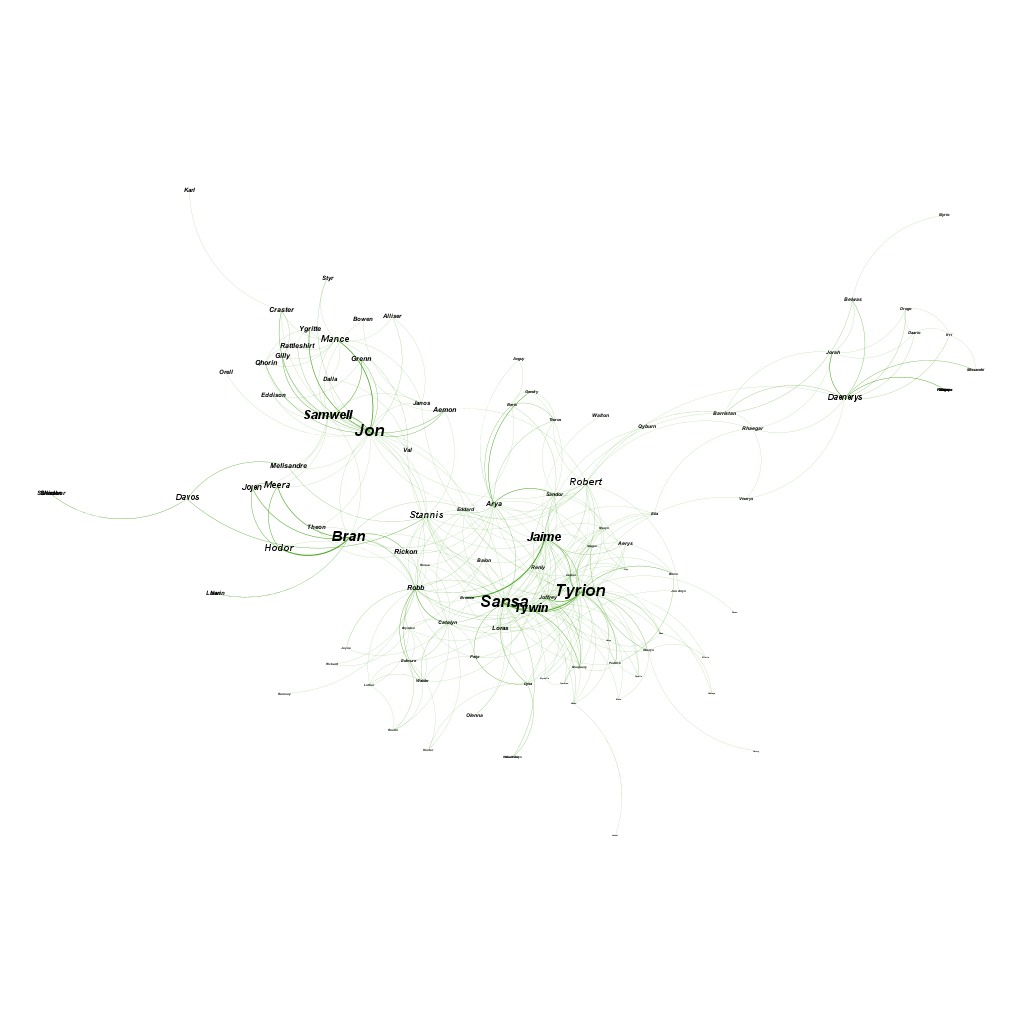